In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [2]:
spark_generator = NewsHeadlines(#locs=['jp'], #['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
    cats = ['business'],
    # business, entertainment, general, health, science, sports, technology
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [12]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='test17')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 6660483#2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

2297226
Title: Semiconductor giant TSMC ended the discount: Phone prices may increase - DonanimHaber
Description: TSMC, one of the world's leading chip manufacturers, has decided to end the discount it offers to its customers who place high-volume orders. The prices of many technological products may increase.
Original Language: Turkish


In [13]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Semiconductor giant TSMC ended the discount: Phone prices may increase - DonanimHaber
Description: TSMC, one of the world's leading chip manufacturers, has decided to end the discount it offers to its customers who place high-volume orders. The prices of many technological products may increase.
Original Language: Turkish
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid 

In [14]:
##############################################
motivation_raw = '''
{
  "introduction": "With TSMC, a major chip maker, ending discounts on large orders, it's likely that the prices of phones and other tech gadgets could go up. To understand this better, we could look at past pricing data of similar products, tracking how changes in manufacturing costs have impacted retail prices. This would help us predict how much more consumers might have to pay for their next smartphone or tablet.",
  "title": "Impact_of_Chip_Costs_on_Consumer_Electronics_Prices"
}


'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [15]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [16]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''
[
  {
    "name": "Consumer Tech Price Increase",
    "description": "Increase in prices of consumer technology products",
    "type": "outcome",
    "observed": true,
    "values": ["No Increase", "Increase"],
    "parents": ["Manufacturer Pricing Strategy", "TSMC Discount Policy Change"]
  },
  {
    "name": "TSMC Discount Policy Change",
    "description": "Change in TSMC's policy regarding discounts on large orders",
    "type": "treatment",
    "observed": true,
    "values": ["No Change", "Policy Change"],
    "parents": ["Economic Conditions"]
  },
  {
    "name": "Global Chip Demand",
    "description": "The global demand for semiconductor chips",
    "type": "treatment",
    "observed": true,
    "values": ["Low Demand", "High Demand"],
    "parents": ["Economic Conditions"]
  },
  {
    "name": "Economic Conditions",
    "description": "The overall state of the global economy",
    "type": "confounder",
    "observed": true,
    "values": ["Poor Economy", "Strong Economy"],
    "parents": []
  },
  {
    "name": "Tech Industry Competition",
    "description": "Level of competition among technology product manufacturers",
    "type": "confounder",
    "observed": true,
    "values": ["Low Competition", "High Competition"],
    "parents": []
  },
  {
    "name": "Chip Supply",
    "description": "Availability of semiconductor chips in the market",
    "type": "mediator",
    "observed": true,
    "values": ["Low Availability", "High Availability"],
    "parents": ["TSMC Discount Policy Change", "Global Chip Demand"]
  },
  {
    "name": "Manufacturer Pricing Strategy",
    "description": "Pricing strategies adopted by technology product manufacturers",
    "type": "mediator",
    "observed": true,
    "values": ["Cost-Driven Strategy", "Demand-Driven Strategy"],
    "parents": ["Chip Supply", "Tech Industry Competition"]
  },
  {
    "name": "Consumer Purchasing Decision",
    "description": "Decision of consumers to purchase technology products",
    "type": "collider",
    "observed": true,
    "values": ["No Purchase", "Purchase"],
    "parents": ["Consumer Tech Price Increase", "Tech Industry Competition"]
  }
]


'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

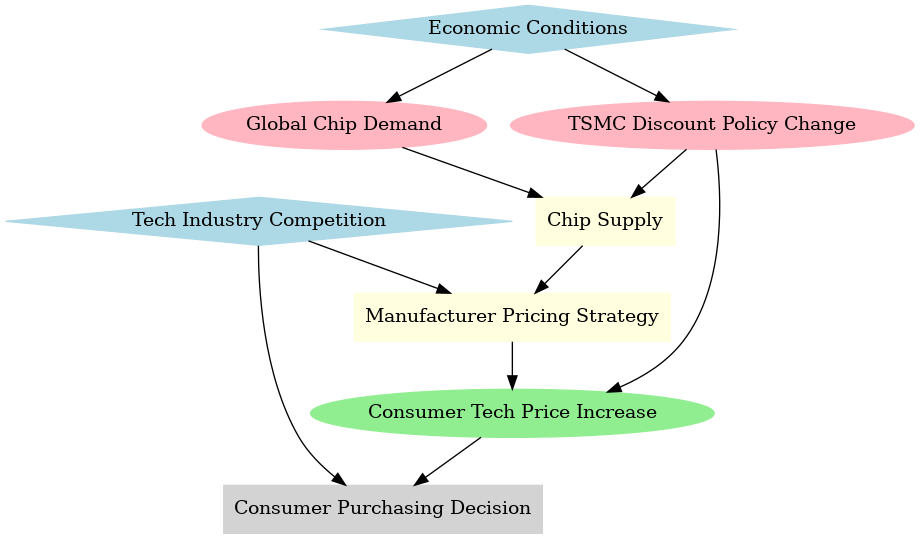

In [17]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [18]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

With TSMC, a major chip maker, ending discounts on large orders, it's likely that the prices of phones and other tech gadgets could go up. To understand this better, we could look at past pricing data of similar products, tracking how changes in manufacturing costs have impacted retail prices. This would help us predict how much more consumers might have to pay for their next smartphone or tablet.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using terms like "affects", "confounder"/"confounding", "mediator"/"mediates"

In [19]:
#################################################

structure_raw = '''

[
    {
        "sentence": "The overall state of the global economy surprisingly influences both the change in TSMC's policy regarding discounts and the global demand for semiconductor chips.",
        "involved": ["Economic Conditions", "TSMC Discount Policy Change", "Global Chip Demand"]
    },
    {
        "sentence": "A shift in TSMC's discount policy and the worldwide demand for chips jointly affect the availability of semiconductor chips in the market.",
        "involved": ["TSMC Discount Policy Change", "Global Chip Demand", "Chip Supply"]
    },
    {
        "sentence": "The level of competition among technology product manufacturers and the availability of chips together shape the pricing strategies adopted by these manufacturers.",
        "involved": ["Tech Industry Competition", "Chip Supply", "Manufacturer Pricing Strategy"]
    },
    {
        "sentence": "Interestingly, both the pricing strategies of manufacturers and TSMC's discount policy directly influence the increase in prices of consumer technology products.",
        "involved": ["Manufacturer Pricing Strategy", "TSMC Discount Policy Change", "Consumer Tech Price Increase"]
    },
    {
        "sentence": "The decision of consumers to purchase technology products is influenced by the increase in tech product prices and the competition level in the tech industry.",
        "involved": ["Consumer Tech Price Increase", "Tech Industry Competition", "Consumer Purchasing Decision"]
    },
    {
        "sentence": "The global economy's state indirectly impacts the availability of chips through its effect on TSMC's discount policy and global chip demand.",
        "involved": ["Economic Conditions", "TSMC Discount Policy Change", "Global Chip Demand", "Chip Supply"]
    },
    {
        "sentence": "The final cost to the consumer for technology products is a result of a complex interaction between economic conditions, company policies, market demands, and competitive strategies.",
        "involved": ["Economic Conditions", "TSMC Discount Policy Change", "Global Chip Demand", "Tech Industry Competition", "Chip Supply", "Manufacturer Pricing Strategy", "Consumer Tech Price Increase"]
    }
]


'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [20]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

With TSMC, a major chip maker, ending discounts on large orders, it's likely that the prices of phones and other tech gadgets could go up. To understand this better, we could look at past pricing data of similar products, tracking how changes in manufacturing costs have impacted retail prices. This would help us predict how much more consumers might have to pay for their next smartphone or tablet.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Economic Conditions" is "Strong Economy" (rather than "Poor Economy")?
2. when "Economic Conditions" is "Poor Economy": what is the probability that "TSMC Discount Policy Change" is "Policy Change" (rather than "No Change")?
3. when "Economic Conditions" is "Strong Economy": what is the probability that "TSMC Discount Policy Chan

In [21]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''
{
  "1": [0.45, 0.55],
  "2": [0.6, 0.7],
  "3": [0.4, 0.5],
  "4": [0.3, 0.4],
  "5": [0.7, 0.8],
  "6": [0.5, 0.6],
  "7": [0.7, 0.8],
  "8": [0.5, 0.6],
  "9": [0.4, 0.5],
  "10": [0.3, 0.4],
  "11": [0.6, 0.7],
  "12": [0.7, 0.8],
  "13": [0.3, 0.4],
  "14": [0.5, 0.6],
  "15": [0.4, 0.5],
  "16": [0.6, 0.7],
  "17": [0.5, 0.6],
  "18": [0.7, 0.8],
  "19": [0.7, 0.8],
  "20": [0.6, 0.7],
  "21": [0.4, 0.5],
  "22": [0.3, 0.4]
}


'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [22]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in ctx['nodes']})

def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, outcome, conditions=conditions).item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

----------------------------  -----------  -------------  -----------------------------------------------------------
TSMC Discount Policy Change   No Change    Policy Change  Change in TSMC's policy regarding discounts on large orders
Global Chip Demand            Low Demand   High Demand    The global demand for semiconductor chips
Consumer Tech Price Increase  No Increase  Increase       Increase in prices of consumer technology products
----------------------------  -----------  -------------  -----------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Economic Conditions' means The overall state of the global economy
'TSMC Discount Policy Change' means Change in TSMC's policy regarding discounts on large orders
'Global Chip Demand' means The global demand for semiconductor chips
'Tech Industry Competition' means Level of competition among technology product manufacturers
'Chip Supply' means Availability of semiconductor chips in the market
'Manufacturer Pricing Strategy' means Pricing strategies adopted by technology product manufacturers
'Consumer Tech Price Increase' means Increase in prices of consumer technology products
'Consumer Purchasing Decision' means Decision of consumers to purchase technology products
Treatment Value    Treatment                    Outcome Value    Outcome                              ATE    Correlation
-----------------  ---------------------------  ---------------  ----------------------------  ----------  -------------
Policy Change      TSMC Discount Policy Change  Increase         Consumer Tech Pr

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                               ATE    Correlation  Outcome
----------------------------------------------------  -----  -------------  ----------------------------------------------------
Strong Economy Economic Conditions                    -0.19          -0.19  Policy Change TSMC Discount Policy Change
Strong Economy Economic Conditions                     0.46           0.46  High Demand Global Chip Demand
Strong Economy Economic Conditions                     0              0     High Competition Tech Industry Competition
Strong Economy Economic Conditions                    -0.01          -0.01  High Availability Chip Supply
Strong Economy Economic Conditions                     0              0     Demand-Driven Strategy Manufacturer Pricing Strategy
Strong Economy Economic Conditions                    -0.05          -0.05  Increase Consumer Tech Price Increase
Strong Economy Economic Conditions                     0.01           0.01  Purchase Consumer 

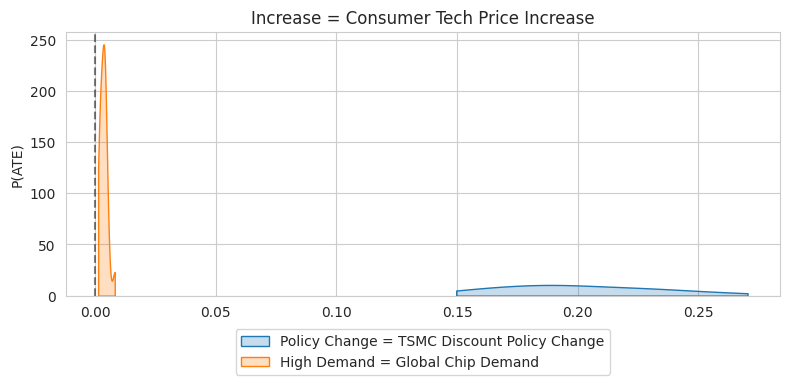

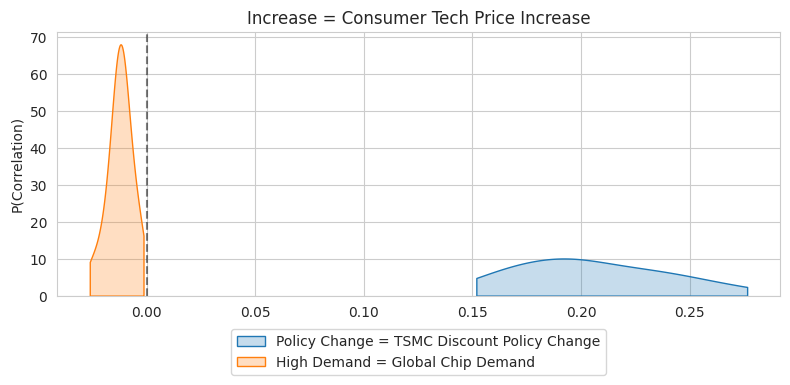

In [23]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
# assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
# assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'], node2['name']).item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

# print(net.backdoor_estimand(treatment1['name'], outcome['name']))
# print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [25]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Economic Conditions' (0='Poor Economy', 1='Strong Economy') means The overall state of the global economy
Variable 'TSMC Discount Policy Change' (0='No Change', 1='Policy Change') means Change in TSMC's policy regarding discounts on l

In [26]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''
{
  "Economic Conditions": {
    "descriptor": ["the global economic climate", "the worldwide economic situation"],
    "subject": "the global economy",
    "predicate0": ["is in a downturn", "is struggling"],
    "predicate1": ["is thriving", "is robust"],
    "pronoun": "it",
    "nounclause0": ["the global economy is in a downturn", "there is a global economic struggle"],
    "nounclause1": ["the global economy is thriving", "there is a robust global economic climate"],
    "preposition": ["in", "across"],
    "domain": ["the world", "global markets"],
    "subclause0": ["economic conditions are poor", "there is a downturn in the economy"],
    "subclause1": ["economic conditions are strong", "the economy is experiencing growth"],
    "condition0": ["when the economy is struggling", "if the global economy faces a downturn"],
    "condition1": ["when the economy is robust", "if the global economy is thriving"],
    "action0": ["if economic policies lead to a downturn", "when global markets decline"],
    "action1": ["if economic policies stimulate growth", "when global markets are booming"]
  },
  "TSMC Discount Policy Change": {
    "descriptor": ["TSMC's pricing policy", "TSMC's discount strategy"],
    "subject": "TSMC",
    "predicate0": ["maintains its current pricing policy", "keeps its discount strategy unchanged"],
    "predicate1": ["alters its pricing policy", "changes its discount strategy"],
    "pronoun": "it",
    "nounclause0": ["TSMC maintains its current pricing policy", "TSMC keeps its discount strategy unchanged"],
    "nounclause1": ["TSMC alters its pricing policy", "TSMC changes its discount strategy"],
    "preposition": ["under", "with"],
    "domain": ["TSMC's policies", "TSMC's pricing"],
    "subclause0": ["TSMC's policy remains the same", "there is no change in TSMC's discounts"],
    "subclause1": ["TSMC introduces a policy change", "TSMC's discounts are altered"],
    "condition0": ["if TSMC maintains its pricing policy", "when TSMC does not change its discounts"],
    "condition1": ["if TSMC changes its pricing policy", "when TSMC alters its discount strategy"],
    "action0": ["if TSMC decides to keep its pricing policy", "when TSMC maintains its discount strategy"],
    "action1": ["if TSMC decides to change its pricing policy", "when TSMC alters its discount strategy"]
  },
  "Global Chip Demand": {
    "descriptor": ["the demand for semiconductor chips", "the global appetite for chips"],
    "subject": "the chip market",
    "predicate0": ["is experiencing a slowdown", "is seeing reduced demand"],
    "predicate1": ["is booming", "is facing high demand"],
    "pronoun": "it",
    "nounclause0": ["there is a slowdown in chip demand", "the chip market sees reduced demand"],
    "nounclause1": ["there is booming chip demand", "the chip market faces high demand"],
    "preposition": ["in", "across"],
    "domain": ["the chip industry", "semiconductor markets"],
    "subclause0": ["chip demand is low", "there's a drop in interest for chips"],
    "subclause1": ["chip demand is high", "there's a surge in interest for chips"],
    "condition0": ["when chip demand is low", "if the market shows reduced interest in chips"],
    "condition1": ["when chip demand is high", "if the market shows increased interest in chips"],
    "action0": ["if the market reduces its demand for chips", "when interest in chips declines"],
    "action1": ["if the market increases its demand for chips", "when interest in chips peaks"]
  },
  "Tech Industry Competition": {
    "descriptor": ["the level of competition in the tech industry", "the competitive landscape of technology companies"],
    "subject": "the tech sector",
    "predicate0": ["experiences minimal competition", "has low competitive pressure"],
    "predicate1": ["faces intense competition", "is highly competitive"],
    "pronoun": "it",
    "nounclause0": ["there is minimal competition in the tech sector", "the tech industry faces low competitive pressure"],
    "nounclause1": ["there is intense competition in the tech sector", "the tech industry is highly competitive"],
    "preposition": ["within", "among"],
    "domain": ["tech companies", "technology firms"],
    "subclause0": ["competition is low among tech companies", "there's minimal rivalry among tech firms"],
    "subclause1": ["competition is fierce among tech companies", "there's intense rivalry among tech firms"],
    "condition0": ["if competition in the tech industry is low", "when tech companies face minimal rivalry"],
    "condition1": ["if competition in the tech industry is high", "when tech companies face intense rivalry"],
    "action0": ["if the tech sector sees reduced competition", "when tech firms experience a decrease in rivalry"],
    "action1": ["if the tech sector becomes more competitive", "when tech firms experience an increase in rivalry"]
  },
  "Chip Supply": {
    "descriptor": ["the availability of semiconductor chips", "the chip supply in the market"],
    "subject": "chip manufacturers",
    "predicate0": ["are facing a shortage of chips", "have limited chip availability"],
    "predicate1": ["have an abundant supply of chips", "are well-stocked with chips"],
    "pronoun": "they",
    "nounclause0": ["there is a chip shortage", "chip availability is limited"],
    "nounclause1": ["there is an abundance of chips", "chip availability is high"],
    "preposition": ["amid", "despite"],
    "domain": ["the market", "industry demands"],
    "subclause0": ["chips are scarce in the market", "the industry faces a chip shortage"],
    "subclause1": ["chips are plentiful in the market", "the industry enjoys a high chip supply"],
    "condition0": ["when chips are scarce", "if there's a shortage in chip supply"],
    "condition1": ["when chips are abundant", "if there's a surplus in chip supply"],
    "action0": ["if chip production decreases", "when chip manufacturers face supply issues"],
    "action1": ["if chip production ramps up", "when chip manufacturers overcome supply issues"]
  },
  "Manufacturer Pricing Strategy": {
    "descriptor": ["the pricing approach of tech manufacturers", "the strategy behind pricing tech products"],
    "subject": "technology companies",
    "predicate0": ["focus on cost-based pricing", "prioritize cost in their pricing"],
    "predicate1": ["adopt a demand-driven pricing approach", "base their pricing on market demand"],
    "pronoun": "they",
    "nounclause0": ["tech companies focus on cost in pricing", "the pricing strategy is cost-driven"],
    "nounclause1": ["tech companies base pricing on demand", "the pricing strategy is demand-driven"],
    "preposition": ["under", "with"],
    "domain": ["market conditions", "consumer trends"],
    "subclause0": ["pricing is based on cost", "cost factors heavily into pricing decisions"],
    "subclause1": ["pricing is based on demand", "market demand influences pricing decisions"],
    "condition0": ["if cost factors are prioritized", "when pricing is based on production costs"],
    "condition1": ["if market demand is prioritized", "when pricing is influenced by consumer interest"],
    "action0": ["if companies focus on cutting costs", "when manufacturers prioritize production costs in pricing"],
    "action1": ["if companies respond to market demand", "when manufacturers align pricing with consumer interest"]
  },
  "Consumer Tech Price Increase": {
    "descriptor": ["the rise in tech product prices", "the increase in consumer tech pricing"],
    "subject": "tech gadgets",
    "predicate0": ["do not become more expensive", "maintain their current price levels"],
    "predicate1": ["see a price increase", "become more expensive"],
    "pronoun": "they",
    "nounclause0": ["tech products do not become more expensive", "there is no price increase for tech gadgets"],
    "nounclause1": ["tech products see a price increase", "tech gadgets become more expensive"],
    "preposition": ["despite", "with"],
    "domain": ["market changes", "economic shifts"],
    "subclause0": ["prices remain stable", "there is no change in pricing"],
    "subclause1": ["prices go up", "there is an upward shift in pricing"],
    "condition0": ["if tech prices remain stable", "when there is no increase in tech product prices"],
    "condition1": ["if tech prices rise", "when tech products become more expensive"],
    "action0": ["if companies decide not to raise prices", "when the market conditions do not necessitate a price increase"],
    "action1": ["if companies decide to raise prices", "when market conditions lead to higher pricing"]
  },
  "Consumer Purchasing Decision": {
    "descriptor": ["the trend in tech purchases", "consumer buying behavior", "the pattern of technology product purchases"],
    "subject": "consumers",
    "predicate0": ["are not buying tech products", "are holding off on tech purchases", "are skipping tech product purchases"],
    "predicate1": ["are buying tech products", "are making tech purchases", "are opting to purchase tech items"],
    "pronoun": "they",
    "nounclause0": ["consumers are not buying technology products", "there's a halt in tech product purchases by consumers", "consumers are refraining from tech purchases"],
    "nounclause1": ["consumers are buying technology products", "there's an uptick in tech product purchases by consumers", "consumers are actively purchasing tech items"],
    "preposition": ["among", "within"],
    "domain": ["consumer groups", "the consumer market"],
    "subclause0": ["a consumer does not buy a tech product", "there's no purchase of tech items"],
    "subclause1": ["a consumer buys a tech product", "there's a purchase of tech items"],
    "condition0": ["if consumers are hesitant about tech purchases", "when consumers decide against buying tech products"],
    "condition1": ["if consumers are inclined towards tech purchases", "when consumers decide to buy tech products"],
    "action0": ["consumers decide not to buy technology products", "consumers hold off on tech purchases"],
    "action1": ["consumers decide to buy technology products", "consumers go ahead with tech purchases"]
  }
}

'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)

In [27]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

With TSMC, a major chip maker, ending discounts on large orders, it's likely that the prices of phones and other tech gadgets could go up. To understand this better, we could look at past pricing data of similar products, tracking how changes in manufacturing costs have impacted retail prices. This would help us predict how much more consumers might have to pay for their next smartphone or tablet.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('TSMC Discount Policy Change') < 0
	2. ATE('Global Chip Demand') > 0
	3. ATE('TSMC Discount Policy Change') > ATE('Global Chip Demand')
	4. |ATE('TSMC Discount Policy Change')| < |ATE('Global Chip Demand')|
	5. CATE('TSMC Discount Policy Change' | 'Economic Conditions' = 0) > 0
	6. CATE('Global Chip Demand' | 

In [28]:
# setting = ctx['questions']
#################################################
settings_raw = '''
{
    "1": {
        "question": "Does a change in TSMC's discount policy typically lead to a decrease in tech product prices?",
        "answer": "no",
        "claim": "A change in TSMC's discount policy does not typically lead to a decrease in tech product prices."
    },
    "2": {
        "question": "Is there usually an increase in tech product prices when the global demand for chips is high?",
        "answer": "yes",
        "claim": "There is usually an increase in tech product prices when the global demand for chips is high."
    },
    "3": {
        "question": "Does a change in TSMC's discount policy have a greater impact on tech product prices than changes in global chip demand?",
        "answer": "no",
        "claim": "Changes in global chip demand have a greater impact on tech product prices than a change in TSMC's discount policy."
    },
    "4": {
        "question": "Is the impact of global chip demand on tech product prices more significant than the impact of TSMC's discount policy change?",
        "answer": "yes",
        "claim": "The impact of global chip demand on tech product prices is more significant than the impact of TSMC's discount policy change."
    },
    "5": {
        "question": "In a poor economy, does a change in TSMC's discount policy typically lead to an increase in tech product prices?",
        "answer": "yes",
        "claim": "In a poor economy, a change in TSMC's discount policy typically leads to an increase in tech product prices."
    },
    "6": {
        "question": "In a poor economy, does high global chip demand typically lead to an increase in tech product prices?",
        "answer": "yes",
        "claim": "In a poor economy, high global chip demand typically leads to an increase in tech product prices."
    },
    "7": {
        "question": "In a poor economy, does high global chip demand have a greater impact on tech product prices than a change in TSMC's discount policy?",
        "answer": "yes",
        "claim": "In a poor economy, high global chip demand has a greater impact on tech product prices than a change in TSMC's discount policy."
    },
    "8": {
        "question": "In a poor economy, is the impact of high global chip demand on tech product prices more significant than the impact of a change in TSMC's discount policy?",
        "answer": "yes",
        "claim": "In a poor economy, the impact of high global chip demand on tech product prices is more significant than the impact of a change in TSMC's discount policy."
    },
    "9": {
        "question": "In a strong economy, does a change in TSMC's discount policy typically lead to an increase in tech product prices?",
        "answer": "yes",
        "claim": "In a strong economy, a change in TSMC's discount policy typically leads to an increase in tech product prices."
    },
    "10": {
        "question": "In a strong economy, does high global chip demand typically lead to an increase in tech product prices?",
        "answer": "yes",
        "claim": "In a strong economy, high global chip demand typically leads to an increase in tech product prices."
    },
    "11": {
        "question": "In a strong economy, does high global chip demand have a lesser impact on tech product prices than a change in TSMC's discount policy?",
        "answer": "no",
        "claim": "In a strong economy, high global chip demand does not have a lesser impact on tech product prices than a change in TSMC's discount policy."
    },
    "12": {
        "question": "In a strong economy, is the impact of a change in TSMC's discount policy on tech product prices less significant than the impact of high global chip demand?",
        "answer": "yes",
        "claim": "In a strong economy, the impact of a change in TSMC's discount policy on tech product prices is less significant than the impact of high global chip demand."
    },
    "13": {
        "question": "Does a change in TSMC's discount policy lead to a greater increase in tech product prices in a poor economy compared to a strong economy?",
        "answer": "yes",
        "claim": "A change in TSMC's discount policy leads to a greater increase in tech product prices in a poor economy compared to a strong economy."
    },
    "14": {
        "question": "Is the impact of a change in TSMC's discount policy on tech product prices more pronounced in a poor economy than in a strong economy?",
        "answer": "no",
        "claim": "The impact of a change in TSMC's discount policy on tech product prices is not more pronounced in a poor economy than in a strong economy."
    },
    "15": {
        "question": "Does high global chip demand have a lesser impact on tech product prices in a strong economy compared to a poor economy?",
        "answer": "yes",
        "claim": "High global chip demand has a lesser impact on tech product prices in a strong economy compared to a poor economy."
    },
    "16": {
        "question": "Is the impact of high global chip demand on tech product prices more significant in a poor economy than in a strong economy?",
        "answer": "yes",
        "claim": "The impact of high global chip demand on tech product prices is more significant in a poor economy than in a strong economy."
    },
    "17": {
        "question": "With low competition in the tech industry, does a change in TSMC's discount policy typically lead to an increase in tech product prices?",
        "answer": "yes",
        "claim": "With low competition in the tech industry, a change in TSMC's discount policy typically leads to an increase in tech product prices."
    },
    "18": {
        "question": "With low competition in the tech industry, does high global chip demand typically lead to a decrease in tech product prices?",
        "answer": "no",
        "claim": "With low competition in the tech industry, high global chip demand does not typically lead to a decrease in tech product prices."
    },
    "19": {
        "question": "With low competition in the tech industry, does high global chip demand have a lesser impact on tech product prices than a change in TSMC's discount policy?",
        "answer": "no",
        "claim": "With low competition in the tech industry, high global chip demand does not have a lesser impact on tech product prices than a change in TSMC's discount policy."
    },
    "20": {
        "question": "With low competition in the tech industry, is the impact of high global chip demand on tech product prices more significant than the impact of a change in TSMC's discount policy?",
        "answer": "yes",
        "claim": "With low competition in the tech industry, the impact of high global chip demand on tech product prices is more significant than the impact of a change in TSMC's discount policy."
    },
    "21": {
        "question": "With high competition in the tech industry, does a change in TSMC's discount policy typically lead to a decrease in tech product prices?",
        "answer": "yes",
        "claim": "With high competition in the tech industry, a change in TSMC's discount policy typically leads to a decrease in tech product prices."
    },
    "22": {
        "question": "With high competition in the tech industry, does high global chip demand typically lead to an increase in tech product prices?",
        "answer": "yes",
        "claim": "With high competition in the tech industry, high global chip demand typically leads to an increase in tech product prices."
    },
    "23": {
        "question": "With high competition in the tech industry, does high global chip demand have a lesser impact on tech product prices than a change in TSMC's discount policy?",
        "answer": "no",
        "claim": "With high competition in the tech industry, high global chip demand does not have a lesser impact on tech product prices than a change in TSMC's discount policy."
    },
    "24": {
        "question": "With high competition in the tech industry, is the impact of a change in TSMC's discount policy on tech product prices less significant than the impact of high global chip demand?",
        "answer": "no",
        "claim": "With high competition in the tech industry, the impact of a change in TSMC's discount policy on tech product prices is not less significant than the impact of high global chip demand."
    },
    "25": {
        "question": "Does a change in TSMC's discount policy lead to a lesser increase in tech product prices with high tech industry competition compared to low competition?",
        "answer": "no",
        "claim": "A change in TSMC's discount policy leads to a greater increase in tech product prices with high tech industry competition compared to low competition."
    },
    "26": {
        "question": "Is the impact of a change in TSMC's discount policy on tech product prices more pronounced with low tech industry competition than with high competition?",
        "answer": "yes",
        "claim": "The impact of a change in TSMC's discount policy on tech product prices is more pronounced with low tech industry competition than with high competition."
    }}

'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [29]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'Impact_of_Chip_Costs_on_Consumer_Electronics_Prices.json'